# HPT PyTorch Lightning Transformer: Introduction

In this chapter, we will introduce transformer. The transformer architecture is a neural network architecture that is based on the attention mechanism [@vasw17a]. It is particularly well suited for sequence-to-sequence tasks, such as machine translation, text summarization, and more. The transformer architecture has been a breakthrough in the field of natural language processing (NLP) and has been the basis for many state-of-the-art models in the field. 

We start with a description of the transformer basics in @sec-transformer-basics. 
@sec-details-implementation provides a detailed description of the implementation of the transformer architecture.
Finally, an example of a transformer implemented in PyTorch Lightning in presented in @sec-transformer-in-lightning.

## Transformer Basics {#sec-transformer-basics}

### Embedding

Word embedding is a technique where words or phrases (so-called tokens) from the vocabulary are mapped to vectors of real numbers.
These vectors capture the semantic properties of the words. Words that are similar in meaning are mapped to vectors that are close to each other in the vector space, and words that are dissimilar are mapped to vectors that are far apart.
Word embeddings are needed for transformers for several reasons:

* Dimensionality Reduction: Word embeddings reduce the dimensionality of the data. Instead of dealing with high-dimensional sparse vectors (like one-hot encoded vectors), we deal with dense vectors of much lower dimensionality.
* Capturing Semantic Similarities: Word embeddings capture semantic similarities between words. This is crucial for tasks like text classification, sentiment analysis, etc., where the meaning of the words is important.
* Handling Unknown Words: If a word is not present in the training data but appears in the test data, one-hot encoding cannot handle it. But word embeddings can handle such situations by mapping the unknown word to a vector that is similar to known words.
* Input to Neural Networks: Transformers, like other neural networks, work with numerical data. Word embeddings provide a way to convert text data into numerical form that can be fed into these networks.

In the context of transformers, word embeddings are used as the initial input representation. The transformer then learns more complex representations by considering the context in which each token appears.

#### Neural Network for Embeddings

Idea for word embeddings: use a relatively simple NN that has one input for every token (word, symbol) in the vocabulary. The output of the NN is a vector of a fixed size, which is the word embedding. The network that is used in this chapter is visualized in @fig-transformer-attention. For simplicity, a 2-dimensional output vector is used in this visualization. The weights of the NN are randomly initialized, and are learned during training.

![Transformer. Computation of the self attention. In this example, we consider two inputs, i.e.,  (1,0) and (0,1). For each input, there are two values, which results in a $2 \times 2$ matrix. In general, when there are $T$ inputs, a $T \times T$ matrix will be generated. Figure credits: [Starmer, Josh: Decoder-Only Transformers, ChatGPTs specific Transformer, Clearly Explained](https://youtu.be/bQ5BoolX9Ag?si=vO5N_cHUULcl-dBn).](./figures_static/transformer.png){#fig-transformer-attention}

All tokens are embedded in this way. For each token there are two numerical values, the embedding vector.
The same network is used for embedding all tokens.
If a longer input is added, it can be embedded with the same net.



#### Positional Encoding for the Embeddings

Positional encoding is added to the input embeddings to give the model some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension as the embeddings so that the two can be summed.

If a token occurs several times, it is embedded several times and receives different embedding vectors, as the position is taken into account by the positional encoding.

### Attention

Attention describes how similar is each token to itself and to all other tokens in the input, e.g., in a sentence.
The attention mechanism can be implemented as a set of layers in neural networks. There are a lot of different possible definitions of "attention" in the literature, but the one we will use here is the following: _the attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and elements' keys_ [@lipp22a].

The goal is to take an average over the features of multiple elements. 
However, instead of weighting each element equally, we want to weight them depending on their actual values.
In other words, we want to dynamically decide on which inputs we want to "attend" more than others.

Calculation of the self-attention:

1. Queries: Calculate two new values from the (two) values of the embedding vector using an NN, which are referred to as query values.
2. Keys: Calculate two new values, called key values, from the (two) values of the embedding vector using an NN.
3. Dot product: Calculate the dot product of the query values and the key values. This is a measure of the similarity of the query and key values.
4. Softmax: Apply the softmax function to the outputs from the dot product. This is a measure of the attention that a token pays to other tokens.
5. Values: Calculate two new values from the (two) values of the embedding vector using an NN, which are referred to as value values.
6. The values are multiplied (weighted) by the values of the softmax function.
7. The weighted values are summed. Now we have the self attention value for the token.


### Self-Attention {#sec-self-attention}

Most attention mechanisms differ in terms of what queries they use, how the key and value vectors are defined, and what score function is used. The attention applied inside the Transformer architecture is called "self-attention". In self-attention, each sequence element provides a key, value, and query. For each element, we perform an attention layer where based on its query, we check the similarity of the all sequence elements' keys, and returned a different, averaged value vector for each element. 


### Masked Self-Attention

Masked self-attention is a variant of the self-attention method described in @sec-self-attention. It asks the question:
How similar is each token to itself and to all preceding tokens in the input (sentence)?
Masked self-attention is an autoregressive mechanism, which means that the attention mechanism is only allowed to look at the tokens that have already been processed.
Calculation of the mask self-attention is identical to the self-attention, but the attention is only calculated for the tokens that have already been processed.
If the masked self-attention method is applied to the first token, the masked self-attention value is exactly the value of the first token, as it only takes itself into account.
For the other tokens, the masked self-attention value is a weighted sum of the values of the previous tokens. The weighting is determined by the similarity of the query values and the key values (dot product and softmax).


### Generation of Outputs

To calculate the output, we use a residual connector that adds the output of the neural network and the output of the masked self-attention method. We thus obtain the residual connection values. The residual connector is used to facilitate training.

To generate the next token, we use another neural network that calculates the output from the (two) residual connection values.
The input layer of the neural network has the size of the residual connection values, the output layer has the number of tokens in the vocabulary as a dimension.

If we now enter the residual connection value of the first token, we receive the token (or the probabilities using Softmax) that is to come next as the output of the neural network. 
This makes sense even if we already know the second token (as with the first token): We can use it to calculate the error of the neural network and train the network.
In addition, the decoder-transformer uses the masked self-attention method to calculate the output, i.e. the encoding and generation of new tokens is done with exactly the same elements of the network.

Note: ChatGPT does not use a new neural network, but the same network that was already used to calculate the embedding. The network is therefore used for embedding, masked self-attention and calculating the output. In the last calculation, the network is inverted, i.e. it is run in the opposite direction to obtain the tokens and not the embeddings as in the original run.


### End-Of-Sequence-Token

The end-of-sequence token is used to signal the end of the input and also to start generating new tokens after the input.
The EOS token recognizes all other tokens, as it comes after all tokens.
When generating tokens, it is important to consider the relationships between the input tokens and the generation of new tokens. 

## Details of the Implementation {#sec-details-implementation}

We will now go into a bit more detail by first looking at the specific implementation of the attention mechanism which is in the Transformer case the (scaled) dot product attention.
The variables shown in @tbl-transformer-variables are used in the Transformer architecture.

Symbol | Variable | Description |
|--|----|----|
| $Q$ | `query` | The query vectors. |
| $K$ | `key` | The key vectors. |
| $V$ | `value` | The value vectors. |
| $d_{\text{model}}$ | `d_model` | The dimensionality of the input and output features of the Transformer. |
| $d_k$ | `d_k` | The hidden dimensionality of the key and query vectors. |
| $d_v$ | `d_v` | The hidden dimensionality of the value vectors. |
| $h$ | `num_heads` | The number of heads in the Multi-Head Attention layer. |
| $B$ | `batch_size` | The batch size. |
| $T$ | `seq_length` | The sequence length. |
| $X$ | `x` | The input features (input elements in the sequence). |
| $W^{Q}$ | `qkv_proj` | The weight matrix to transform the input to the query vectors. |
| $W^{K}$ | `qkv_proj` | The weight matrix to transform the input to the key vectors. |
| $W^{V}$ | `qkv_proj` | The weight matrix to transform the input to the value vectors. |
| $W^{O}$ | `o_proj` | The weight matrix to transform the concatenated output of the Multi-Head Attention layer to the final output. |
| $N$ | `num_layers` | The number of layers in the Transformer. |
| $PE_{(pos,i)}$ | `positional_encoding` | The positional encoding for position $pos$ and hidden dimensionality $i$. |

: Variables used in the Transformer architecture. {#tbl-transformer-variables}


Summarizing the ideas from @sec-transformer-basics, an attention mechanism has usually four parts we need to specify [@lipp22a]:

* *Query*: The query is a feature vector that describes what we are looking for in the sequence, i.e., what would we maybe want to pay attention to.
* *Keys*: For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is "offering", or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.
* *Score function*: To rate which elements we want to pay attention to, we need to specify a score function $f_{attn}$. The score function takes the query and a key as input, and output the score/attention weight of the query-key pair. It is usually implemented by simple similarity metrics like a dot product, or a small MLP.
* *Values*: For each input element, we also have a value vector. This feature vector is the one we want to average over.


The weights of the average are calculated by a softmax over all score function outputs. Hence, we assign those value vectors a higher weight whose corresponding key is most similar to the query. If we try to describe it with pseudo-math, we can write: 

$$
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i
$$

Visually, we can show the attention over a sequence of words as follows:

![Attention over a sequence of words. For every word, we have one key and one value vector. The query is compared to all keys with a score function (in this case the dot product) to determine the weights. The softmax is not visualized for simplicity. Finally, the value vectors of all words are averaged using the attention weights. Figure taken from @lipp22a](./figures_static/attention_example.png)




### Dot Product Attention

 Our goal is to have an attention mechanism with which any element in a sequence can attend to any other while still being efficient to compute. The dot product attention takes as input a set of queries $Q\in\mathbb{R}^{T\times d_k}$, keys $K\in\mathbb{R}^{T\times d_k}$ and values $V\in\mathbb{R}^{T\times d_v}$ where $T$ is the sequence length, and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively. For simplicity, we neglect the batch dimension for now. The attention value from element $i$ to $j$ is based on its similarity of the query $Q_i$ and key $K_j$, using the dot product as the similarity metric (in @fig-transformer-attention, we considered $Q_2$ and $K_1$ as well as $Q_2$ and $K_2$). 
 The dot product attention is calculated as follows:

$$
\text{Attention}(Q,K,V)=\text{softmax}\left(QK^T\right) V 
$$ {#eq-dot-product-attention}

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $T\times T$. Each row represents the attention logits for a specific element $i$ to all other elements in the sequence. On these, we apply a softmax and multiply with the value vector to obtain a weighted mean (the weights being determined by the attention). 

### Scaled Dot Product Attention

An additional aspect is the scaling of the dot product using a scaling factor of $1/\sqrt{d_k}$. This scaling factor is crucial to maintain an appropriate variance of attention values after initialization.
We initialize our layers with the intention of having equal variance throughout the model, and hence, $Q$ and $K$ might also have a variance close to $1$. However, performing a dot product over two vectors with a variance $\sigma^2$ results in a scalar having $d_k$-times higher variance: 

$$
q_i \sim \mathcal{N}(0,\sigma^2), k_i \sim \mathcal{N}(0,\sigma^2) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = \sigma^4\cdot d_k
$$


If we do not scale down the variance back to $\sim\sigma^2$, the softmax over the logits will already saturate to $1$ for one random element and $0$ for all others. The gradients through the softmax will be close to zero so that we can't learn the parameters appropriately. Note that the extra factor of $\sigma^2$, i.e., having $\sigma^4$ instead of $\sigma^2$, is usually not an issue, since we keep the original variance $\sigma^2$ close to $1$ anyways.
@eq-dot-product-attention can be modified as follows to calculate the dot product attention:

$$
\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V.
$$

Another perspective on this scaled dot product attention mechanism offers the computation graph which is visualized in @fig-scaled-dot-product-attn.

![Scaled dot product attention. Figure credit @vasw17a](./figures_static/scaled_dot_product_attn.png){#fig-scaled-dot-product-attn}

The block `Mask (opt.)` in the diagram above represents the optional masking of specific entries in the attention matrix. This is for instance used if we stack multiple sequences with different lengths into a batch. To still benefit from parallelization in PyTorch, we pad the sentences to the same length and mask out the padding tokens during the calculation of the attention values. This is usually done by setting the respective attention logits to a very low value. 

After we have discussed the details of the scaled dot product attention block, we can write a function below which computes the output features given the triple of queries, keys, and values:


## Example: Transformer in Lightning {#sec-transformer-in-lightning}

The following code is based on [https://github.com/phlippe/uvadlc_notebooks/tree/master](https://github.com/phlippe/uvadlc_notebooks/tree/master) (Author: Phillip Lippe)

First, we import the necessary libraries and download the pretrained models.


In [1]:
import os
import numpy as np
import random
import math
import json
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib
import seaborn as sns

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [2]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial6"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from spotPython.utils.device import getDevice
device = getDevice()
print("Device:", device)

Device: mps


In [4]:
# Setting the seed
pl.seed_everything(42)

Seed set to 42


42

Two pre-trained models are downloaded below. Make sure to have adjusted your `CHECKPOINT_PATH` before running this code if not already done.


In [5]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

### Downloading the Pretrained Models


In [6]:
# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Error:\n", e)

### The Transformer Architecture

We will implement the Transformer architecture by hand. As the architecture is so popular, there already exists a Pytorch module `nn.Transformer` ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)) and a [tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) on how to use it for next token prediction. However, we will implement it here ourselves, to get through to the smallest details.


### Attention Mechanism


In [7]:
def scaled_dot_product(q, k, v, mask=None):
    """
    Compute scaled dot product attention.
    Args:
        q: Queries
        k: Keys
        v: Values
        mask: Mask to apply to the attention logits

    Returns:
        Tuple of (Values, Attention weights)

    Examples:
    >>> seq_len, d_k = 1, 2
        pl.seed_everything(42)
        q = torch.randn(seq_len, d_k)
        k = torch.randn(seq_len, d_k)
        v = torch.randn(seq_len, d_k)
        values, attention = scaled_dot_product(q, k, v)
        print("Q\n", q)
        print("K\n", k)
        print("V\n", v)
        print("Values\n", values)
        print("Attention\n", attention)
    """
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

Note that our code above supports any additional dimensionality in front of the sequence length so that we can also use it for batches. However, for a better understanding, let's generate a few random queries, keys, and value vectors, and calculate the attention outputs:


In [8]:
seq_len, d_k = 1, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Seed set to 42


Q
 tensor([[0.3367, 0.1288]])
K
 tensor([[0.2345, 0.2303]])
V
 tensor([[-1.1229, -0.1863]])
Values
 tensor([[-1.1229, -0.1863]])
Attention
 tensor([[1.]])


### Multi-Head Attention

The scaled dot product attention allows a network to attend over a sequence. However, often there are multiple different aspects a sequence element wants to attend to, and a single weighted average is not a good option for it. This is why we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys, and sub-values, which we pass through the scaled dot product attention independently. Afterward, we concatenate the heads and combine them with a final weight matrix. Mathematically, we can express this operation as:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer with the learnable parameters $W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$, and $W^{O}\in\mathbb{R}^{h\cdot d_v\times d_{out}}$ ($D$ being the input dimensionality). Expressed in a computational graph, we can visualize it as in @fig-multihead-attention.

![Multi-Head Attention. Figure taken from @vasw17a](./figures_static/multihead_attention.png){#fig-multihead-attention}

How are we applying a Multi-Head Attention layer in a neural network, where we do not have an arbitrary query, key, and value vector as input?
Looking at the computation graph in @fig-multihead-attention, a simple but effective implementation is to set the current feature map in a NN, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$ ($B$ being the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$). The consecutive weight matrices $W^{Q}$, $W^{K}$, and $W^{V}$ can transform $X$ to the corresponding feature vectors that represent the queries, keys, and values of the input. Using this approach, we can implement the Multi-Head Attention module below.

As a consequence, if the embedding dimension is 4, then 1, 2 or 4 heads can be used, but not 3. If 4 heads are used, then the dimension of the query, key and value vectors is 1. If 2 heads are used, then the dimension of the query, key and value vectors is $D=2$. If 1 head is used, then the dimension of the query, key and value vectors is $D=4$. The number of heads is a hyperparameter that can be adjusted. The number of heads is usually 8 or 16.


In [9]:
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be >= 2-dim. with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [10]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dim. must be 0 modulo number of heads."
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        
        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)
        
        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)
        
        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)
        
        if return_attention:
            return o, attention
        else:
            return o

### Permutation Equivariance

One crucial characteristic of the multi-head attention is that it is permutation-equivariant with respect to its inputs. This means that if we switch two input elements in the sequence, e.g. $X_1\leftrightarrow X_2$ (neglecting the batch dimension for now), the output is exactly the same besides the elements 1 and 2 switched. Hence, the multi-head attention is actually looking at the input not as a sequence, but as a set of elements. This property makes the multi-head attention block and the Transformer architecture so powerful and widely applicable! But what if the order of the input is actually important for solving the task, like language modeling? The answer is to encode the position in the input features, which we will take a closer look in @sec-positional-encoding.


### Transformer Encoder

Next, we will look at how to apply the multi-head attention block inside the Transformer architecture. Originally, the Transformer model was designed for machine translation. Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language and generates an attention-based representation. On the other hand, the decoder attends over the encoded information and generates the translated sentence in an autoregressive manner, as in a standard RNN. While this structure is extremely useful for Sequence-to-Sequence tasks with the necessity of autoregressive decoding, we will focus here on the encoder part. Many advances in NLP have been made using pure encoder-based Transformer models (if interested, models include the BERT-family [@devl18a], the Vision Transformer [@deso20a], and more). We will also mainly focus on the encoder part. If you have understood the encoder architecture, the decoder is a very small step to implement as well. The full Transformer architecture looks as shown in @fig-transformer-architecture.

![Transformer architecture. Figure credit: @vasw17a](./figures_static/transformer_architecture.png){#fig-transformer-architecture}


The encoder consists of $N$ identical blocks that are applied in sequence. Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above. The output is added to the original input using a residual connection, and we apply a consecutive Layer Normalization on the sum. Overall, it calculates 
$$
\text{LayerNorm}(x+\text{Multihead}(x,x,x))
$$
($x$ being $Q$, $K$ and $V$ input to the attention layer). The residual connection is crucial in the Transformer architecture for two reasons: 

1. Similar to ResNets, Transformers are designed to be very deep. Some models contain more than 24 blocks in the encoder. Hence, the residual connections are crucial for enabling a smooth gradient flow through the model.
2. Without the residual connection, the information about the original sequence is lost. Remember that the Multi-Head Attention layer ignores the position of elements in a sequence, and can only learn it based on the input features. Removing the residual connections would mean that this information is lost after the first attention layer (after initialization), and with a randomly initialized query and key vector, the output vectors for position $i$ has no relation to its original input. All outputs of the attention are likely to represent similar/same information, and there is no chance for the model to distinguish which information came from which input element. An alternative option to residual connection would be to fix at least one head to focus on its original input, but this is very inefficient and does not have the benefit of the improved gradient flow.

### Layer Normalization and Feed-Forward Network

The Layer Normalization also plays an important role in the Transformer architecture as it enables faster training and provides small regularization. Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence.

We are not using Batch Normalization because it depends on the batch size which is often small with Transformers (they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language as the features of words tend to have a much higher variance (there are many, very rare words which need to be considered for a good distribution estimate).

Additionally to the Multi-Head Attention, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically. Specifically, the model uses a Linear$\to$ReLU$\to$Linear MLP. The full transformation including the residual connection can be expressed as:  

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

This MLP adds extra complexity to the model and allows transformations on each sequence element separately. You can imagine as this allows the model to "post-process" the new information added by the previous Multi-Head Attention, and prepare it for the next attention block. Usually, the inner dimensionality of the MLP is 2-8$\times$ larger than $d_{\text{model}}$, i.e. the dimensionality of the original input $x$. The general advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.

Finally, after looking at all parts of the encoder architecture, we can start implementing it below. We first start by implementing a single encoder block. Additionally to the layers described above, we will add dropout layers in the MLP and on the output of the MLP and Multi-Head Attention for regularization.


In [11]:
class EncoderBlock(nn.Module):
    
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()
        
        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)
        
        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )
        
        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        
        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)
        
        return x

Based on this block, we can implement a module for the full Transformer encoder. Additionally to a forward function that iterates through the sequence of encoder blocks, we also provide a function called `get_attention_maps`. The idea of this function is to return the attention probabilities for all Multi-Head Attention blocks in the encoder. This helps us in understanding, and in a sense, explaining the model. However, the attention probabilities should be interpreted with a grain of salt as it does not necessarily reflect the true interpretation of the model (there is a series of papers about this, including @jain19a and @wieg19a).


In [12]:
class TransformerEncoder(nn.Module):
    
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList(
            [EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Positional Encoding {#sec-positional-encoding}

We have discussed before that the Multi-Head Attention block is permutation-equivariant, and cannot distinguish whether an input comes before another one in the sequence or not. In tasks like language understanding, however, the position is important for interpreting the input words. The position information can therefore be added via the input features. We could learn a embedding for every possible position, but this would not generalize to a dynamical input sequence length. Hence, the better option is to use feature patterns that the network can identify from the features and potentially generalize to larger sequences. The specific pattern chosen by @vasw17a are sine and cosine functions of different frequencies, as follows:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ represents the position encoding at position $pos$ in the sequence, and hidden dimensionality $i$. These values, concatenated for all hidden dimensions, are added to the original input features (in the Transformer visualization above, see "Positional encoding"), and constitute the position information. We distinguish between even ($i \text{ mod } 2=0$) and uneven ($i \text{ mod } 2=1$) hidden dimensionalities where we apply a sine/cosine respectively. The intuition behind this encoding is that you can represent $PE_{(pos+k,:)}$ as a linear function of $PE_{(pos,:)}$, which might allow the model to easily attend to relative positions. The wavelengths in different dimensions range from $2\pi$ to $10000\cdot 2\pi$.

The positional encoding is implemented below. The code is taken from the PyTorch tutorial [https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model) about Transformers on NLP and adjusted for our purposes.


In [13]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing 
        # the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # register_buffer => Tensor which is not a parameter,
        # but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the 
        # state dict (e.g. when we save the model) 
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

To understand the positional encoding, we can visualize it below. We will generate an image of the positional encoding over hidden dimensionality and position in a sequence. Each pixel, therefore, represents the change of the input feature we perform to encode the specific position. Let's do it below.


<Figure size 672x480 with 0 Axes>

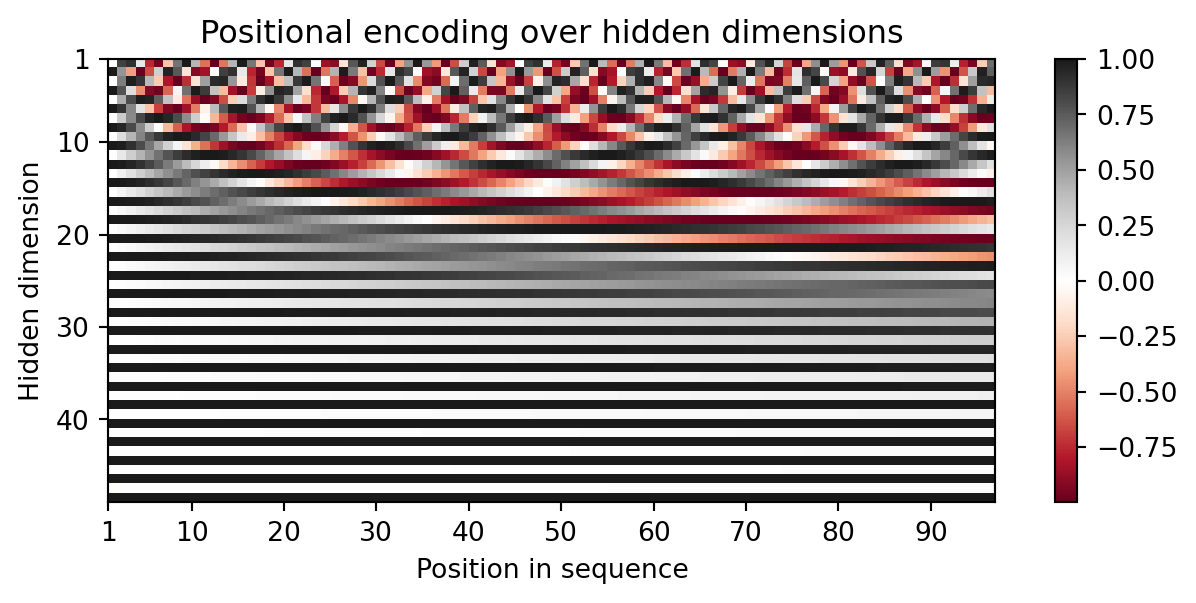

In [14]:
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.set_cmap('cividis')
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

You can clearly see the sine and cosine waves with different wavelengths that encode the position in the hidden dimensions. Specifically, we can look at the sine/cosine wave for each hidden dimension separately, to get a better intuition of the pattern. Below we visualize the positional encoding for the hidden dimensions $1$, $2$, $3$ and $4$.


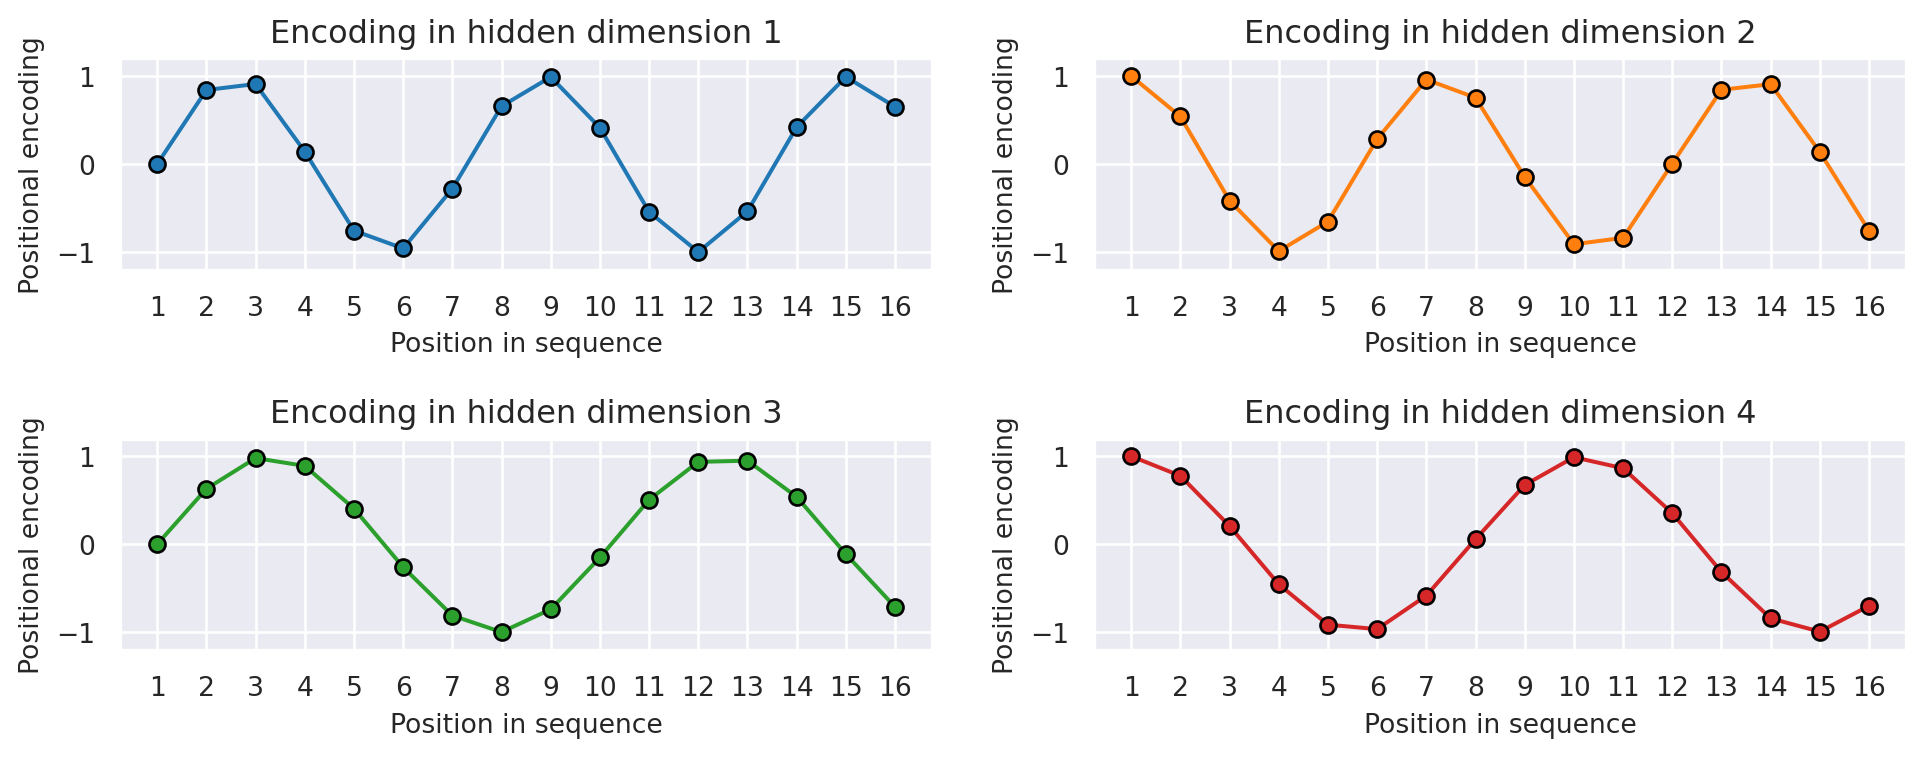

In [15]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o",
                markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

As we can see, the patterns between the hidden dimension $1$ and $2$ only differ in the starting angle. The wavelength is $2\pi$, hence the repetition after position $6$. The hidden dimensions $2$ and $3$ have about twice the wavelength. 

### Learning Rate Warm-up

One commonly used technique for training a Transformer is learning rate warm-up. This means that we gradually increase the learning rate from 0 on to our originally specified learning rate in the first few iterations. Thus, we slowly start learning instead of taking very large steps from the beginning. In fact, training a deep Transformer without learning rate warm-up can make the model diverge and achieve a much worse performance on training and testing. Take for instance the following plot by [Liu et al. (2019)](https://arxiv.org/pdf/1908.03265.pdf) comparing Adam-vanilla (i.e. Adam without warm-up) vs Adam with a warm-up:

![Warm-up comparison. Figure taken from @liu19a](./figures_static/warmup_loss_plot.png)

Clearly, the warm-up is a crucial hyperparameter in the Transformer architecture. Why is it so important? There are currently two common explanations. Firstly, Adam uses the bias correction factors which however can lead to a higher variance in the adaptive learning rate during the first iterations. Improved optimizers like [RAdam](https://arxiv.org/abs/1908.03265) have been shown to overcome this issue, not requiring warm-up for training Transformers. Secondly, the iteratively applied Layer Normalization across layers can lead to very high gradients during the first iterations, which can be solved by using [Pre-Layer Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf) (similar to Pre-Activation ResNet), or replacing Layer Normalization by other techniques ([Adaptive Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf), [Power Normalization](https://arxiv.org/abs/2003.07845)). 

Nevertheless, many applications and papers still use the original Transformer architecture with Adam, because warm-up is a simple, yet effective way of solving the gradient problem in the first iterations. There are many different schedulers we could use. For instance, the original Transformer paper used an exponential decay scheduler with a warm-up. However, the currently most popular scheduler is the cosine warm-up scheduler, which combines warm-up with a cosine-shaped learning rate decay. We can implement it below, and visualize the learning rate factor over epochs. 


In [16]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)
        
    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]
    
    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

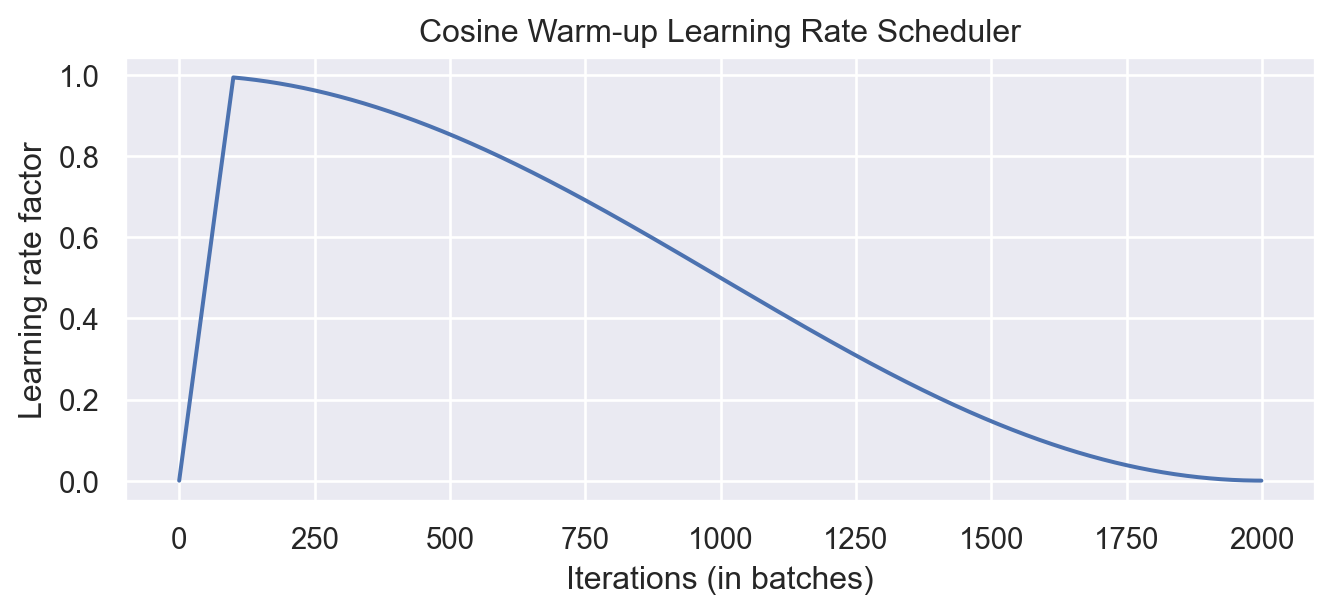

In [17]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In the first 100 iterations, we increase the learning rate factor from 0 to 1, whereas for all later iterations, we decay it using the cosine wave. Pre-implementations of this scheduler can be found in the popular NLP Transformer library [huggingface](https://huggingface.co/transformers/main_classes/optimizer_schedules.html?highlight=cosine#transformers.get_cosine_schedule_with_warmup).

### PyTorch Lightning Module

Finally, we can embed the Transformer architecture into a PyTorch lightning module. PyTorch Lightning simplifies our training and test code, as well as structures the code nicely in separate functions. We will implement a template for a classifier based on the Transformer encoder. Thereby, we have a prediction output per sequence element. If we would need a classifier over the whole sequence, the common approach is to add an additional `[CLS]` token to the sequence (`CLS` stands for classification, i.e., the first token of every sequence is always a special classification token, `CLS`). However, here we focus on tasks where we have an output per element. 

Additionally to the Transformer architecture, we add a small input network (maps input dimensions to model dimensions), the positional encoding, and an output network (transforms output encodings to predictions).
We also add the learning rate scheduler, which takes a step each iteration instead of once per epoch. This is needed for the warmup and the smooth cosine decay. The training, validation, and test step is left empty for now and will be filled for our task-specific models.


In [18]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        ) 

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        
        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer, 
                                             warmup=self.hparams.warmup, 
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError    

    def test_step(self, batch, batch_idx):
        raise NotImplementedError   

## Experiment: Sequence to Sequence

After having finished the implementation of the Transformer architecture, we can start experimenting and apply it to various tasks. We will focus on parallel Sequence-to-Sequence.

A Sequence-to-Sequence task represents a task where the input _and_ the output is a sequence, not necessarily of the same length. Popular tasks in this domain include machine translation and summarization. For this, we usually have a Transformer encoder for interpreting the input sequence, and a decoder for generating the output in an autoregressive manner. Here, however, we will go back to a much simpler example task and use only the encoder. Given a sequence of $N$ numbers between $0$ and $M$, the task is to reverse the input sequence. In Numpy notation, if our input is $x$, the output should be $x$[::-1]. Although this task sounds very simple, RNNs can have issues with such because the task requires long-term dependencies. Transformers are built to support such, and hence, we expect it to perform very well. 

### Dataset and Data Loaders

First, let's create a dataset class below.


In [19]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        
        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))
  
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

We create an arbitrary number of random sequences of numbers between 0 and `num_categories-1`. The label is simply the tensor flipped over the sequence dimension. We can create the corresponding data loaders below. 


In [20]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000),
                                batch_size=128,
                                shuffle=True,
                                drop_last=True,
                                pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

In [21]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([0, 4, 1, 2, 5, 5, 7, 6, 9, 6, 3, 1, 9, 3, 1, 9])
Labels:     tensor([9, 1, 3, 9, 1, 3, 6, 9, 6, 7, 5, 5, 2, 1, 4, 0])


During training, we pass the input sequence through the Transformer encoder and predict the output for each input token. We use the standard Cross-Entropy loss to perform this. Every number is represented as a one-hot vector. Remember that representing the categories as single scalars decreases the expressiveness of the model extremely as $0$ and $1$ are not closer related than $0$ and $9$ in our example. An alternative to a one-hot vector is using a learned embedding vector as it is provided by the PyTorch module `nn.Embedding`. However, using a one-hot vector with an additional linear layer as in our case has the same effect as an embedding layer (`self.input_net` maps one-hot vector to a dense vector, where each row of the weight matrix represents the embedding for a specific category).

### The Reverse Predictor Class

To implement the training dynamic, we create a new class inheriting from `TransformerPredictor` and overwriting the training, validation and test step functions, which were left empty in the base class. We also add a `_calculate_loss` function to calculate the loss and accuracy for a batch.


In [22]:
class ReversePredictor(TransformerPredictor):
    
    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()
        
        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        
        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc
        
    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")
    
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

Finally, we can create a training function. We create a `pl.Trainer` object, running for $N$ epochs, logging in TensorBoard, and saving our best model based on the validation. Afterward, we test our models on the test set. 

### Gradient Clipping

An additional parameter we pass to the trainer here is `gradient_clip_val`. This clips the norm of the gradients for all parameters before taking an optimizer step and prevents the model from diverging if we obtain very high gradients at, for instance, sharp loss surfaces (see many good blog posts on gradient clipping, like [DeepAI glossary](https://deepai.org/machine-learning-glossary-and-terms/gradient-clipping)).
For Transformers, gradient clipping can help to further stabilize the training during the first few iterations, and also afterward.
In plain PyTorch, you can apply gradient clipping via `torch.nn.utils.clip_grad_norm_(...)` (see [documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html#torch.nn.utils.clip_grad_norm_)). The clip value is usually between 0.5 and 10, depending on how harsh you want to clip large gradients. 

### Implementation of the Lightning Trainer

The Lightning trainer can be implemented as follows:


In [23]:
def train_reverse(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir, 
                         callbacks=[ModelCheckpoint(save_weights_only=True,
                                    mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=10,
                         gradient_clip_val=5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = ReversePredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
        trainer.fit(model, train_loader, val_loader)
        
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}
    
    model = model.to(device)
    return model, result

### Training the Model

Finally, we can train the model. In this setup, we will use a single encoder block and a single head in the Multi-Head Attention. This is chosen because of the simplicity of the task, and in this case, the attention can actually be interpreted as an "explanation" of the predictions (compared to the other papers above dealing with deep Transformers). 


In [24]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

GPU available: True (mps), used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial6/ReverseTask.ckpt`


Missing logger folder: ../saved_models/tutorial6/ReverseTask/lightning_logs


Found pretrained model, loading...


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

The warning of PyTorch Lightning regarding the number of workers can be ignored for now. As the data set is so simple and the `__getitem__` finishes a neglectable time, we don't need subprocesses to provide us the data (in fact, more workers can slow down the training as we have communication overhead among processes/threads). First, let's print the results:


In [25]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


As we would have expected, the Transformer can correctly solve the task. 


## Visualizing Attention Maps

How does the attention in the Multi-Head Attention block looks like for an arbitrary input? Let's try to visualize it below.


In [26]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

The object `attention_maps` is a list of length $N$ where $N$ is the number of layers. Each element is a tensor of shape [Batch, Heads, SeqLen, SeqLen], which we can verify below.


In [27]:
attention_maps[0].shape

torch.Size([128, 1, 16, 16])

Next, we will write a plotting function that takes as input the sequences, attention maps, and an index indicating for which batch element we want to visualize the attention map. We will create a plot where over rows, we have different layers, while over columns, we show the different heads. Remember that the softmax has been applied for each row separately.


In [28]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]
    
    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    cax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
    cbar = fig.colorbar(ax[0][0].imshow(attn_maps[0][0], origin='lower', vmin=0), cax=cax)
    cbar.set_label('Attention')
    plt.show()

Finally, we can plot the attention map of our trained Transformer on the reverse task:


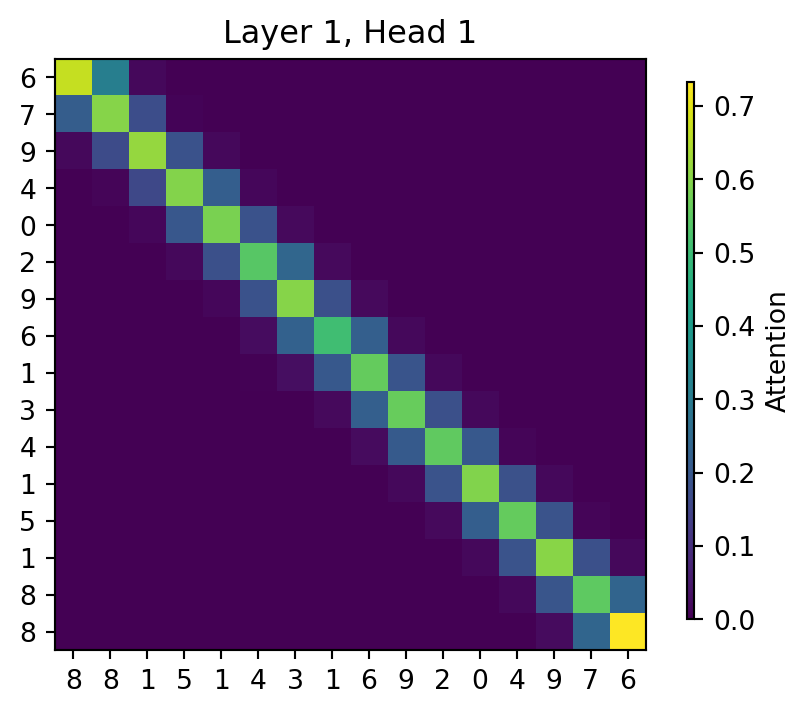

In [29]:
plot_attention_maps(data_input, attention_maps, idx=0)

The model has learned to attend to the token that is on the flipped index of itself. Hence, it actually does what we intended it to do. We see that it however also pays some attention to values close to the flipped index. This is because the model doesn't need the perfect, hard attention to solve this problem, but is fine with this approximate, noisy attention map. The close-by indices are caused by the similarity of the positional encoding, which we also intended with the positional encoding.

## Conclusion

In this chapter, we took a closer look at the Multi-Head Attention layer which uses a scaled dot product between queries and keys to find correlations and similarities between input elements. The Transformer architecture is based on the Multi-Head Attention layer and applies multiple of them in a ResNet-like block. The Transformer is a very important, recent architecture that can be applied to many tasks and datasets. Although it is best known for its success in NLP, there is so much more to it. We have seen its application on sequence-to-sequence tasks. Its property of being permutation-equivariant if we do not provide any positional encodings, allows it to generalize to many settings. Hence, it is important to know the architecture, but also its possible issues such as the gradient problem during the first iterations solved by learning rate warm-up. If you are interested in continuing with the study of the Transformer architecture, please have a look at the blog posts listed in the "Further Reading" section below.

## Additional Considerations

### Complexity and Path Length

We can compare the self-attention operation with our other common layer competitors for sequence data: convolutions and recurrent neural networks. In @fig-comparison-conv-rnn you can find a table by @vasw17a on the complexity per layer, the number of sequential operations, and maximum path length. The complexity is measured by the upper bound of the number of operations to perform, while the maximum path length represents the maximum number of steps a forward or backward signal has to traverse to reach any other position. The lower this length, the better gradient signals can backpropagate for long-range dependencies. Let's take a look at the table in @fig-comparison-conv-rnn.

![Comparison of complexity and path length of different sequence layers. Table taken from @lipp22a](./figures_static/comparison_conv_rnn.png){#fig-comparison-conv-rnn}


$n$ is the sequence length, $d$ is the representation dimension and $k$ is the kernel size of convolutions. In contrast to recurrent networks, the self-attention layer can parallelize all its operations making it much faster to execute for smaller sequence lengths. However, when the sequence length exceeds the hidden dimensionality, self-attention becomes more expensive than RNNs. One way of reducing the computational cost for long sequences is by restricting the self-attention to a neighborhood of inputs to attend over, denoted by $r$. Nevertheless, there has been recently a lot of work on more efficient Transformer architectures that still allow long dependencies, of which you can find an overview in the paper by @tay20a if interested.


## Further Reading

There are of course many more tutorials out there about attention and Transformers. Below, we list a few that are worth exploring if you are interested in the topic and might want yet another perspective on the topic after this one:

* [Transformer: A Novel Neural Network Architecture for Language Understanding (Jakob Uszkoreit, 2017)](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html) - The original Google blog post about the Transformer paper, focusing on the application in machine translation.
* [The Illustrated Transformer (Jay Alammar, 2018)](http://jalammar.github.io/illustrated-transformer/) - A very popular and great blog post intuitively explaining the Transformer architecture with many nice visualizations. The focus is on NLP.
* [Attention? Attention! (Lilian Weng, 2018)](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) - A nice blog post summarizing attention mechanisms in many domains including vision.
* [Illustrated: Self-Attention (Raimi Karim, 2019)](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a) - A nice visualization of the steps of self-attention. Recommended going through if the explanation below is too abstract for you.
* [The Transformer family (Lilian Weng, 2020)](https://lilianweng.github.io/lil-log/2020/04/07/the-transformer-family.html) - A very detailed blog post reviewing more variants of Transformers besides the original one.